# Set up

In [1]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

Using TensorFlow backend.


## Workflow

1. **Prepare data**
    1. **Transform** data i.e. taking log, scaling, and differencing.
> If data is transformed, prediction must be converted by **inversing transformation** operations.
    2. **Split** data into three sets e.g. train, validation and test set. For example, 60:20:20 proportion.
    3. For deep learning, we need to reshape data **to [Keras](https://keras.io)** format.
        1. Number of periods to used as model's input.
        2. Number of periods to forecast as model's output.


2. **Grid search** for the best hyper-parameters (configs).
    1. For each hyper-parameter, **fit the model** using **train set**.  
    2. **Walk forward validation** over the **validation set**.  
    3. **Measure** the model's performance via some metrics. In this case, we use RMSE.  
    4. For deep learning techniques, **repeat** step A-C n times because deep learning is stochastic.
    5. **Select** the best config based on RMSE.
    
    
3. **Forecast**.
    1. **Combine** train and validation set called it **train2 set**.
    2. **Refit model** using **train2 set** and the config from step 1.
    3. **Walk forward validation** over the **test set**.
    4. **Measure** the model's performance using RMSE.
    5. For deep learning techniques, **repeat** step B-D.
    6. **Return** model's performance, predicted.
    
    
4. **Evaluate** models including
    - Naive or Persistent model (NAIVE) 
    - Exponential Smoothing (ES) 
    - Seasonal Autoregressive Integrated Moving Average (SARIMA)
    - Multilayer Perceptron (MLP) 
    - Long Short-Term Memory (LSTM)

## Structure of defined functions
1. `data_` means data preparation steps
    1. `data_split`
    2. `data_transform`
    3. `data_reshape`
    
    
2. `model_` means model steps
    1. `model_config`
    2. `model_fit`
    3. `model_predict`


3. `eval_`


4. `plot_`

# Prepare data

## Import price data

โหลดข้อมูลราคาข้าวเปลือกที่เกษตรกรขายได้ 3 ชนิดข้าว ได้แก่ ข้าวหอมมะลิ (`hml`) ข้าวเจ้าขาว (`wht`) และข้าวเหนียว (`glu`)  
นอกจากนี้ ยังเพิ่มข้อมูล metadata ประกอบด้วยตัวย่อ(abb) ชื่อย่อ (shortname) และ ชื่อเต็ม(fullname)

In [2]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

## Policy data
เพิ่มข้อมูล dummy ปีที่มีนโยบายจำนำข้าวทุกเมล็ดของรัฐบาลยิ่งลักษณ์ ระหว่าง Oct 2010 - Feb 2014

In [3]:
exo = pd.DataFrame(index = wht.index)
exo['pledge_scheme'] = 0
exo.loc['2011-10':'2014-2'] = 1

## Data Transformation

In [5]:
for price in prices:
  price.scaled, price.scaler = data_transform(price, method=None)
  price.train, price.validate, price.train2, price.test = data_split(price.scaled)
  print(price.meta.abb, price.train.size, price.validate.size, price.test.size)

hml 259 85 85
wht 259 85 85
glu 259 85 85


# Exponential Smoothing

## Generate Parameter Grid

In [6]:
# trend = [None]
# damped = [False]
# seasonal = [None, 'add', 'mul']
# conf1 = model_configs(trend, damped, seasonal)

trend = ['add', 'mul']
damped = [False, True]
seasonal = [None, 'add', 'mul']
# conf2 = model_configs(trend, damped, seasonal)

# ets_configs = [*conf1, *conf2]
ets_configs = model_configs(trend, damped, seasonal)
ets_configs

[('add', False, None),
 ('add', False, 'add'),
 ('add', False, 'mul'),
 ('add', True, None),
 ('add', True, 'add'),
 ('add', True, 'mul'),
 ('mul', False, None),
 ('mul', False, 'add'),
 ('mul', False, 'mul'),
 ('mul', True, None),
 ('mul', True, 'add'),
 ('mul', True, 'mul')]

## Define function

In [13]:
def ets_fit(data, config, n_periods=12):
  trend, damped, seasonal = config
  return ets(data, trend=trend, damped=damped,
             seasonal=seasonal,seasonal_periods=n_periods
            ).fit(use_boxcox='log')

def ets_forecast(model_fitted, data, n_forecast=4):
  scaler = getattr(data, "scaler")
  df = pd.DataFrame(model_fitted.forecast(n_forecast),
                    columns=["yhat_scaled"])
  df['yhat'] = scaler.inverse_transform(df)
  return df['yhat']

def ets_walk_forward(data, config, search_mode=False, n_forecast=4):
  train, test = select_traintest(data, search_mode)
  data_ = pd.concat([train,test])
  N = data_.shape[0]
  n_test = test.shape[0]
  n_yhat = n_test+1 # +1 for count adjustment
  yhat = np.empty((n_yhat, n_forecast))
  
  history = train
  for i in range(n_yhat):
    model_fitted = ets_fit(history, config)
    yhat[i] = ets_forecast(model_fitted, data, n_forecast)
    if i < n_yhat-1:
      history = history.append(test.iloc[i]) 

  yhat = pd.DataFrame(yhat,
                      columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                      index=data_.index[-n_test-1:])

  return yhat

In [14]:
# test
# config = ets_configs[0]
# fitted = ets_fit(hml.scaled, config)
# yhat = ets_walk_forward(hml, config, search_mode=True)
# scores = model_measure(hml, yhat, config)
# scores

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
add-False-None,"1,232.6238",773.2564,0.0594,687.9490,398.8807,0.0311,"1,115.1376",706.7849,0.0546,"1,442.9568",923.7551,0.0709,"1,684.4520","1,063.6052",0.0810


# Run

In [15]:
ets_model = [ets_fit, ets_forecast, ets_walk_forward, ets_configs]

In [16]:
%%time
n_forecast=4
for price in prices:
  price.ets_grid_result, price.ets_config = grid_search(price, ets_model, n_forecast=n_forecast)
  price.ets_yhat = forecast(price, ets_model, price.ets_config, n_forecast=n_forecast)

{('add-False-None',): {'rmse': 1232.6238, 'mae': 773.2564, 'mape': 0.0594}}
{('add-False-add',): {'rmse': 1428.9367, 'mae': 863.0766, 'mape': 0.0666}}
{('add-False-mul',): {'rmse': 1456.4919, 'mae': 926.2758, 'mape': 0.0717}}
{('add-True-None',): {'rmse': 1235.6707, 'mae': 771.2672, 'mape': 0.0593}}
{('add-True-add',): {'rmse': 1326.3842, 'mae': 831.5626, 'mape': 0.0644}}
{('add-True-mul',): {'rmse': 1307.2729, 'mae': 839.555, 'mape': 0.0656}}
{('mul-False-None',): {'rmse': 1235.2917, 'mae': 775.5002, 'mape': 0.0596}}
{('mul-False-add',): {'rmse': 1434.0116, 'mae': 865.4826, 'mape': 0.0666}}
{('mul-False-mul',): {'rmse': 1412.4736, 'mae': 870.7516, 'mape': 0.0659}}
{('mul-True-None',): {'rmse': 1230.768, 'mae': 769.444, 'mape': 0.0592}}
{('mul-True-add',): {'rmse': 1440.2755, 'mae': 869.2159, 'mape': 0.067}}
{('mul-True-mul',): {'rmse': 1568.3361, 'mae': 1078.3189, 'mape': 0.0851}}
hml 259 85 85
{('add-False-None',): {'rmse': 1045.6521, 'mae': 607.1432, 'mape': 0.0636}}
{('add-False-ad

In [29]:
for price in prices:
  print(price.ets_config)

('mul', True, None)
('add', False, None)
('add', True, None)


In [19]:
path = '../results/result_ets_4.pkl'

if(os.path.isfile(path)):
    result = joblib.load(path)
else:
    result = dict()
    for price in prices:
        result[price.meta.abb] = [price.ets_grid_result, price.ets_config, price.ets_yhat]
    joblib.dump(result, path)

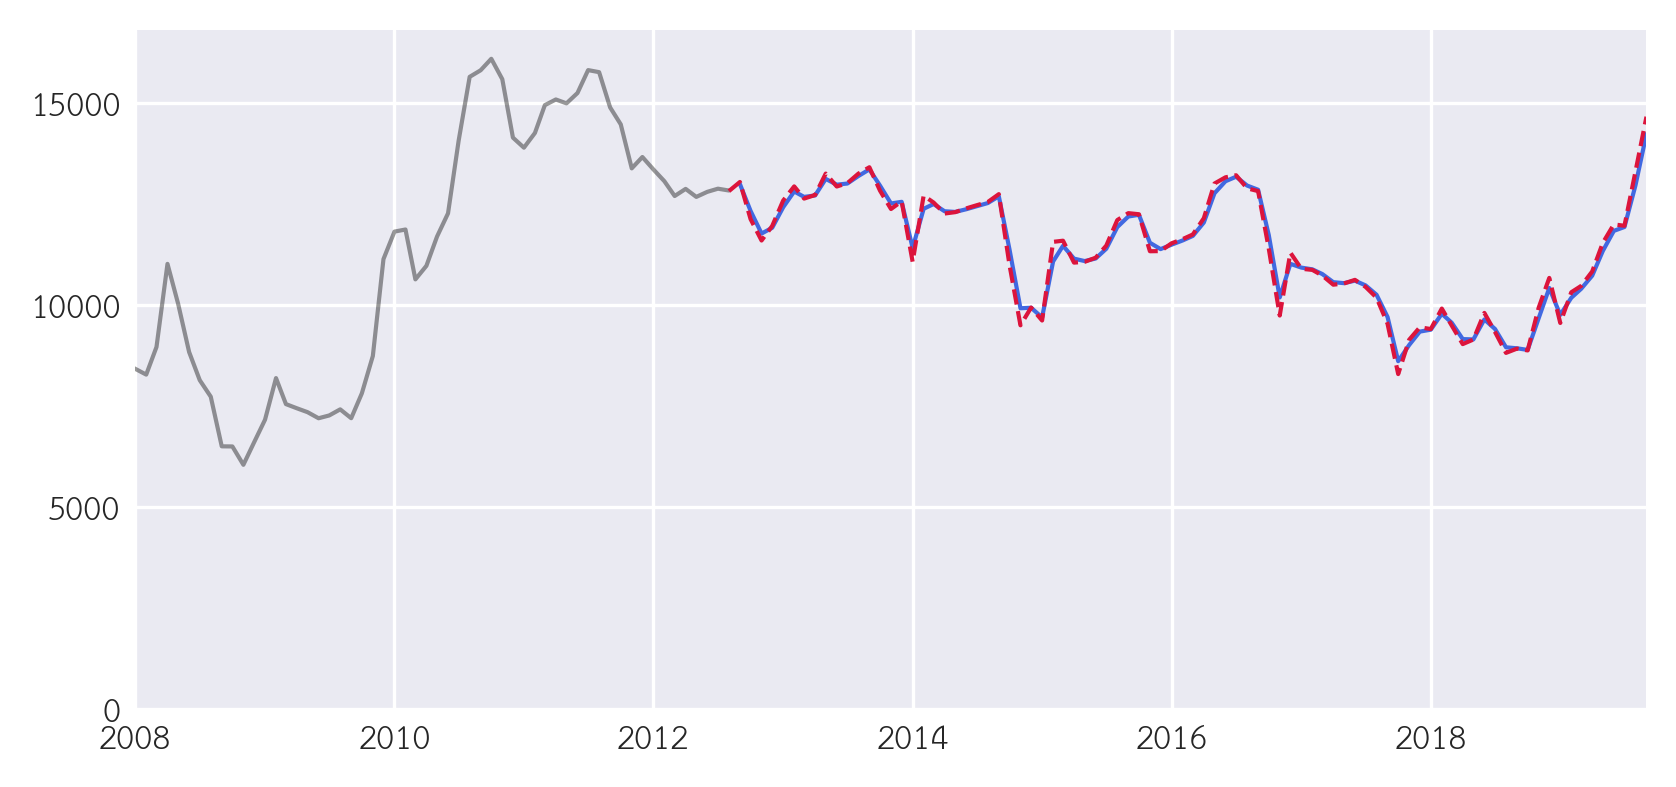

In [21]:
plot_fcast(glu, 'ets', step=1)

In [24]:
model_measure(hml, hml.ets_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,864.5041,600.3250,0.0488,463.2144,308.7569,0.0252,782.7994,539.2258,0.0437,"1,012.6514",695.5840,0.0565,"1,199.3512",857.7333,0.0696


In [25]:
model_measure(wht, wht.ets_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,495.3012,379.6580,0.0474,295.9516,222.6656,0.0275,465.1051,370.6372,0.0462,576.9546,442.3458,0.0553,643.1935,482.9835,0.0606


In [26]:
model_measure(glu, glu.ets_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,871.8920,664.5522,0.0605,512.1047,363.7199,0.0334,802.7196,600.9746,0.0551,997.1670,785.2024,0.0717,"1,175.5767",908.3117,0.0820
